# About

**Author** : htrf88<br>
**Description** : Bias in AI coursework Task 3 implementation

> **Note**
> Plese run notebook cells in order to recreate the output

# Setup

## Common imports

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,.3f}'.format

## Train, test, evaluation setup

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
import shap

In [3]:
def encode_and_scale(df):
    disc_ft = ['workclass', 'occupation', 'relationship']
    cont_ft = ['age', 'education_num', 'hours_per_week']
    label_mapping = {}
    le = LabelEncoder()
    for i in disc_ft:
        df[i] = le.fit_transform(df[i])
        label_mapping[i] = dict(zip(le.classes_, le.transform(le.classes_)))

    df[cont_ft] = StandardScaler().fit_transform(df[cont_ft])
    return df

In [4]:
def train(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(max_depth=8, random_state=42)
    cv_results = cross_validate(clf, X_test, y_test, cv=10)
    clf.fit(X_train, y_train)
    print("10 fold corss validation accuracy: %.2f%%\n" % (cv_results['test_score'].mean()*100.0))
    return clf

In [5]:
def plot_feature_imp(clf, features):
    print("Feature importance")
    feat_imp = pd.DataFrame(clf.feature_importances_, columns=['weight'])
    feat_imp['feature'] = features
    feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
    sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", color='b', aspect=2, height=4)

In [6]:
def shap_summery(model, samples):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(samples)
    shap.summary_plot(shap_values[1], samples)

## Model bias evaluation functions

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def check_bias(model, X_test, y_test, features, exclude_cols=[]):
    # Generate the required data for evaluation
    df = X_test.copy()
    df['true'] = y_test
    if exclude_cols:
        df['pred'] = model.predict(X_test.drop(exclude_cols, axis=1))
        df['score'] = model.predict_proba(X_test.drop(exclude_cols, axis=1))[:,1]
    else:
        df['pred'] = model.predict(X_test)
        df['score'] = model.predict_proba(X_test)[:,1]
    
    bias_df = []
    for feature in features:
        # Calculate confusion matrix for privilaged and unprivilaged classes
        priv, unpriv = df[df[feature] == 1], df[df[feature] == 0]
        TN_p, FP_p, FN_p, TP_p = confusion_matrix(priv.true, priv.pred).ravel()
        TN_u, FP_u, FN_u, TP_u = confusion_matrix(unpriv.true, unpriv.pred).ravel()
        # Calculate metrics of bias
        rate_pos_outcome_p = (TP_p + FP_p)/(TN_p + FP_p + FN_p + TP_p)  # rate of +ve outcome privilaged
        rate_pos_outcome_u = (TP_u + FP_u)/(TN_u + FP_u + FN_u + TP_u)  # rate of +ve outcome unprivilaged
        # Statistical piraty : diff of the rate of +ve outcomes of unprivileged and privileged groups
        stat_piraty = rate_pos_outcome_u - rate_pos_outcome_p
        # Equal oppurtunity : diff of true +ve rates of unprivileged and the privileged groups
        eq_odds_diff = TP_u/(TP_u + FN_u) - TP_p/(TP_p + FN_p)
        # Avg odds diff : average of difference in false +ve rates and true +ve rates between unprivileged 
        # and privileged groups
        avg_odds_diff = ((FP_u/(FP_u + TN_u) - FP_p/(FP_p + TN_p)) + eq_odds_diff)/2
        # Disparate Impact : ratio of prob of +ve outcomes between the unprivileged and privileged group
        disp_impact = rate_pos_outcome_u / rate_pos_outcome_p

        res = pd.DataFrame(index=['Statistical Parity Diff', 'Equal Opportunity Diff', 
                                 'Average Odds Diff', 'Disparate Impact'])
        res['value'] = [stat_piraty, eq_odds_diff, avg_odds_diff, disp_impact]
        res['biased'] = [~i for i in [-0.1 <= stat_piraty <= 0.1, 
                                    -0.1 <= eq_odds_diff <= 0.1, 
                                    -0.1 <= avg_odds_diff <= 0.1, 
                                    0.8 <= disp_impact <= 1.25 ]]
        bias_df.append(res)
    
    print(" "*25 + ''.join([i.ljust(15) for i in features]))
    print(pd.concat(bias_df, axis=1))
    
    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.3, 0.5)
    plt.subplot(1,2,1)
    for feature in features:
        for i in df[feature].unique():
            y_true, y_score = df[df[feature] == i].true, df[df[feature] == i].score
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2,
                    label=f'{feature} {"favoured" if i == 1 else "deprived"} (AUC = %0.2f)'%roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
        
    # Plot precision-recall curve
    plt.subplot(1,2,2)
    legend = []
    for feature in features:
        for i in df[feature].unique():
            y_true, y_score = df[df[feature] == i].true, df[df[feature] == i].score
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            avg_prec = average_precision_score(y_true, y_score)
            legend.append(f'{feature} {"favoured" if i == 1 else "deprived"} (AP = %0.2f)' % avg_prec)
            plt.step(recall, precision, where='post')

        # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.legend(legend)
    plt.grid(True)
    plt.show()

# Task 3.2 - Data Analysis

## 3.2.1 Load dataset

In [8]:
FEATURES = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
            "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

CONTINUOUS = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
DISCRETE = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", 
            "salary"]

data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv", 
                   na_values='?', names=FEATURES)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  47985 non-null  object
 14  salary          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## 3.2.2 Inspect different demographic groups within the data

Distribution of numerical features

In [9]:
num_info = data[CONTINUOUS].describe().transpose()
num_info.drop(columns=['count'], axis=0, inplace=True)
num_info['var'] = [data[i].var() for i in CONTINUOUS]
num_info.transpose()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
mean,38.644,"189,664.135",10.078,"1,079.068",87.502,40.422
std,13.711,"105,604.025",2.571,"7,452.019",403.005,12.391
min,17.000,"12,285.000",1.000,0.000,0.000,1.000
25%,28.000,"117,550.500",9.000,0.000,0.000,40.000
50%,37.000,"178,144.500",10.000,0.000,0.000,40.000
75%,48.000,"237,642.000",12.000,0.000,0.000,45.000
max,90.000,"1,490,400.000",16.000,"99,999.000","4,356.000",99.000
var,187.978,"11,152,210,185.575",6.610,"55,532,588.036","162,412.669",153.548


Distribution of selective numerical features with seperated by the outcome of the target variable

In [10]:
continuous = ['age', 'education_num', 'hours_per_week']
data[continuous+['salary']].groupby(['salary']).agg(['count', 'mean', 'std', 'var']).transpose()

salary                    <=50K       >50K
age            count 37,155.000 11,687.000
               mean      36.872     44.275
               std       14.104     10.559
               var      198.926    111.492
education_num  count 37,155.000 11,687.000
               mean       9.598     11.603
               std        2.438      2.383
               var        5.942      5.677
hours_per_week count 37,155.000 11,687.000
               mean      38.840     45.453
               std       12.357     11.091
               var      152.692    123.014

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `sex`

In [11]:
data[continuous+['salary','sex']].groupby(['sex', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

sex                      Female                 Male          
salary                    <=50K      >50K      <=50K      >50K
age            count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      36.279    42.219     37.249    44.642
               std       14.387    10.505     13.909    10.527
               var      206.999   110.352    193.448   110.818
education_num  count 14,423.000 1,769.000 22,732.000 9,918.000
               mean       9.825    11.832      9.455    11.562
               std        2.307     2.202      2.507     2.411
               var        5.322     4.849      6.283     5.814
hours_per_week count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      35.876    40.679     40.721    46.304
               std       11.855    11.854     12.300    10.729
               var      140.542   140.511    151.295   115.117

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `race`

In [12]:
data[continuous+['salary','race']].groupby(['race', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

race                 Amer-Indian-Eskimo         ...      White           
salary                            <=50K   >50K  ...      <=50K       >50K
age            count            415.000 55.000  ... 31,155.000 10,607.000
               mean              36.128 40.964  ...     36.929     44.390
               std               12.368  9.469  ...     14.303     10.621
               var              152.957 89.665  ...    204.582    112.803
education_num  count            415.000 55.000  ... 31,155.000 10,607.000
               mean               9.176 10.982  ...      9.629     11.603
               std                2.151  2.198  ...      2.433      2.373
               var                4.628  4.833  ...      5.919      5.630
hours_per_week count            415.000 55.000  ... 31,155.000 10,607.000
               mean              39.817 43.709  ...     38.995     45.552
               std               12.256  8.956  ...     12.627     11.160
               var              150.213 80.210  ...    159.446    124.545

[12 rows x 10 columns]

Analysing categorical data

In [13]:
for i in DISCRETE[:-1]:
    print("Demographic group: ", i)
    print("3 most frequent values: " + ', '.join(data[i].value_counts()[:3].index.tolist()))
    unq = data[i].unique()
    info = pd.DataFrame(columns=["Count"], index=unq)
    info["Count"] = [data[data[i] == j].shape[0] for j in unq]
    info[">50K (%)"] = [data[(data[i] == j) & (data.salary == '>50K')].shape[0] for j in unq]
    info[">50K (%)"] = np.round(info[">50K (%)"]/info["Count"], 3)
    info = info.sort_values(by=['>50K (%)'], ascending=False)
    print("Population size and % of population earning >50K a year for this demographic as described below")
    display(info.transpose())
    print("")


Demographic group:  workclass
3 most frequent values: Private, Self-emp-not-inc, Local-gov
Population size and % of population earning >50K a year for this demographic as described below


,Self-emp-inc,Federal-gov,Local-gov,Self-emp-not-inc,State-gov,Private,Without-pay,Never-worked,NaN
Count,"1,695.000","1,432.000","3,136.000","3,862.000","1,981.000","33,906.000",21.000,10.000,0.000
>50K (%),0.553,0.392,0.296,0.279,0.268,0.218,0.095,0.000,nan



Demographic group:  education
3 most frequent values: HS-grad, Some-college, Bachelors
Population size and % of population earning >50K a year for this demographic as described below


,Prof-school,Doctorate,Masters,Bachelors,Assoc-acdm,Assoc-voc,Some-college,HS-grad,12th,7th-8th,10th,9th,5th-6th,11th,1st-4th,Preschool
Count,834.000,594.000,"2,657.000","8,025.000","1,601.000","2,061.000","10,878.000","15,784.000",657.000,955.000,"1,389.000",756.000,509.000,"1,812.000",247.000,83.000
>50K (%),0.740,0.726,0.549,0.413,0.258,0.253,0.190,0.159,0.073,0.065,0.063,0.054,0.053,0.051,0.032,0.012



Demographic group:  marital_status
3 most frequent values: Married-civ-spouse, Never-married, Divorced
Population size and % of population earning >50K a year for this demographic as described below


,Married-civ-spouse,Married-AF-spouse,Divorced,Married-spouse-absent,Widowed,Separated,Never-married
Count,"22,379.000",37.000,"6,633.000",628.000,"1,518.000","1,530.000","16,117.000"
>50K (%),0.446,0.378,0.101,0.092,0.084,0.065,0.045



Demographic group:  occupation
3 most frequent values: Prof-specialty, Craft-repair, Exec-managerial
Population size and % of population earning >50K a year for this demographic as described below


,Exec-managerial,Prof-specialty,Armed-Forces,Protective-serv,Tech-support,Sales,Craft-repair,Transport-moving,Adm-clerical,Machine-op-inspct,Farming-fishing,Handlers-cleaners,Other-service,Priv-house-serv,NaN
Count,"6,086.000","6,172.000",15.000,983.000,"1,446.000","5,504.000","6,112.000","2,355.000","5,611.000","3,022.000","1,490.000","2,072.000","4,923.000",242.000,0.000
>50K (%),0.478,0.451,0.333,0.313,0.290,0.268,0.226,0.204,0.137,0.123,0.116,0.067,0.041,0.012,nan



Demographic group:  relationship
3 most frequent values: Husband, Not-in-family, Own-child
Population size and % of population earning >50K a year for this demographic as described below


,Wife,Husband,Not-in-family,Unmarried,Other-relative,Own-child
Count,"2,331.000","19,716.000","12,583.000","5,125.000","1,506.000","7,581.000"
>50K (%),0.469,0.449,0.101,0.060,0.035,0.015



Demographic group:  race
3 most frequent values: White, Black, Asian-Pac-Islander
Population size and % of population earning >50K a year for this demographic as described below


,Asian-Pac-Islander,White,Other,Black,Amer-Indian-Eskimo
Count,"1,519.000","41,762.000",406.000,"4,685.000",470.000
>50K (%),0.269,0.254,0.123,0.121,0.117



Demographic group:  sex
3 most frequent values: Male, Female
Population size and % of population earning >50K a year for this demographic as described below


,Male,Female
Count,"32,650.000","16,192.000"
>50K (%),0.304,0.109



Demographic group:  native_country
3 most frequent values: United-States, Mexico, Philippines
Population size and % of population earning >50K a year for this demographic as described below


,France,India,Taiwan,Iran,England,Greece,Yugoslavia,Japan,Canada,Italy,Cambodia,Hungary,Ireland,China,Philippines,Germany,Hong,Cuba,United-States,Poland,Portugal,South,Thailand,Scotland,Jamaica,Ecuador,Haiti,Puerto-Rico,Honduras,Laos,Peru,Vietnam,Trinadad&Tobago,El-Salvador,Nicaragua,Mexico,Dominican-Republic,Columbia,Outlying-US(Guam-USVI-etc),Guatemala,Holand-Netherlands,NaN
Count,38.000,151.000,65.000,59.000,127.000,49.000,23.000,92.000,182.000,105.000,28.000,19.000,37.000,122.000,295.000,206.000,30.000,138.000,"43,832.000",87.000,67.000,115.000,30.000,21.000,106.000,45.000,75.000,184.000,20.000,23.000,46.000,86.000,27.000,155.000,49.000,951.000,103.000,85.000,23.000,88.000,1.000,0.000
>50K (%),0.421,0.411,0.400,0.373,0.370,0.367,0.348,0.348,0.346,0.324,0.321,0.316,0.297,0.295,0.288,0.282,0.267,0.246,0.244,0.195,0.179,0.174,0.167,0.143,0.142,0.133,0.120,0.109,0.100,0.087,0.087,0.081,0.074,0.071,0.061,0.049,0.049,0.047,0.043,0.034,0.000,nan


# Task 3.3 - Conventional implementation

## Data preparation for ML 

In [14]:
# Drop nan values and the index column
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# Removing anomalies form the data
# Removing individual of age over 80 years working full time because it is highly unsual
data = data[~((data['age'] >= 80) & (data['hours_per_week'] >= 20))]
data.shape

(45111, 15)

In [15]:
data['salary'] = data['salary'].map(lambda x : 1 if x == '>50K' else 0)

# replace native_country, race and sex with 1 if the value belongs to the privilaged group
# and 0 in it belong to the unprivilaged group
data['native_country'] = data['native_country'].apply(lambda x: 1 if x == "United-States" else 0)
data['race'] = data['race'].apply(lambda x: 1 if x == "White" else 0) # privilaged group - White
data['sex'] = data['sex'].apply(lambda x: 1 if x == "Male" else 0)    # privilaged group - Male


# Encode marital-status
data['marital_status'] = data['marital_status'].replace(['Divorced','Married-spouse-absent',
                                                         'Never-married','Separated','Widowed'], 0)
data['marital_status'] = data['marital_status'].replace(['Married-AF-spouse','Married-civ-spouse'], 1)


# Simplify workclass
def workclass(x):
    if 'gov' in x:
        return 'gov'
    elif x == 'Private':
        return 'private'
    elif x == 'Self-emp-inc':
        return 'self_employed'
    else:
        return 'without_pay'

data['workclass'] = data['workclass'].apply(workclass)


# Simplify occupation
def occupation(x):
    if x in ['Adm-clerical', 'Exec-managerial']:
        return 'White-Collar'
    elif x in ['Craft-repair', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Transport-moving']:
        return 'Blue-Collar'
    elif x in ['Other-service', 'Priv-house-serv', 'Protective-serv', 'Tech-support']:
        return 'Service'
    elif x == 'Prof-specialty':
        return 'Professional'
    else:
        return x

data['occupation'] = data['occupation'].apply(occupation)


# Encode capital_gain and capital_loss
data['capital_gain'] = data['capital_gain'].map(lambda x: 1 if x > 0 else 0)
data['capital_loss'] = data['capital_loss'].map(lambda x: 1 if x > 0 else 0)
CONTINUOUS.remove('capital_gain')
CONTINUOUS.remove('capital_loss')
DISCRETE += ['capital_gain', 'capital_loss']

data = data.drop(['education', 'fnlwgt'], axis=1)
data

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,gov,13,0,White-Collar,Not-in-family,1,1,1,0,40,1,0
1,50,without_pay,13,1,White-Collar,Husband,1,1,0,0,13,1,0
2,38,private,9,0,Blue-Collar,Not-in-family,1,1,0,0,40,1,0
3,53,private,7,1,Blue-Collar,Husband,0,1,0,0,40,1,0
4,28,private,13,1,Professional,Wife,0,0,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,private,13,0,Professional,Own-child,1,1,0,0,40,1,0
45218,39,private,13,0,Professional,Not-in-family,1,0,0,0,36,1,0
45219,38,private,13,1,Professional,Husband,1,1,0,0,50,1,0
45220,44,private,13,0,White-Collar,Own-child,0,1,1,0,40,1,0


In [16]:
 X, y = encode_and_scale(data.drop(['salary'], axis=1)), data['salary']

## 3.3.2 Naively splitting the dataset into training and testing dataset

10 fold corss validation accuracy: 84.25%

                         sex            race           native_country 
                         value  biased  value  biased  value  biased
Statistical Parity Diff -0.172    True -0.088   False -0.038   False
Equal Opportunity Diff  -0.116    True -0.079   False  0.010   False
Average Odds Diff       -0.090   False -0.051   False  0.000   False
Disparate Impact         0.277    True  0.547    True  0.793    True


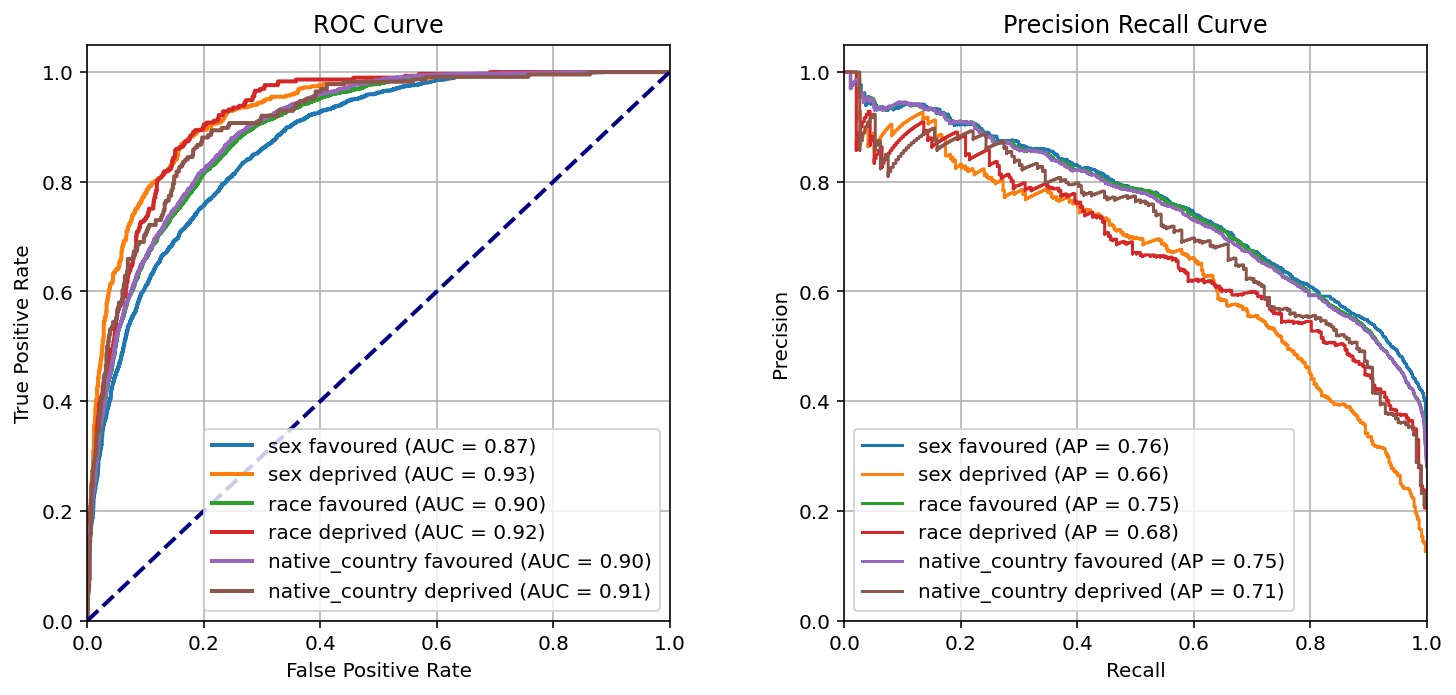

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, 
                                                    random_state=42)
clf_naive = train(X_train, y_train, X_test, y_test)
check_bias(clf_naive, X_test, y_test, ["sex", "race", "native_country"])

## 3.3.4 Unbiased split of the data into training and testing set

In [18]:
data['demo_group'] = data['sex'].astype(str) + data['race'].astype(str) + data['salary'].astype(str)
data.demo_group.value_counts()

110    18214
010    10404
111     8733
100     2712
000     2596
011     1452
101      786
001      214
Name: demo_group, dtype: int64

In [19]:
# Stratified split of dataset into train and test data w.r.t above demographic groups 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=data.demo_group)
del data['demo_group']

10 fold corss validation accuracy: 83.97%

                         sex            race           native_country 
                         value  biased  value  biased  value  biased
Statistical Parity Diff -0.166    True -0.078   False -0.021   False
Equal Opportunity Diff  -0.145    True -0.065   False  0.022   False
Average Odds Diff       -0.105    True -0.043   False  0.017   False
Disparate Impact         0.269    True  0.579    True  0.882   False


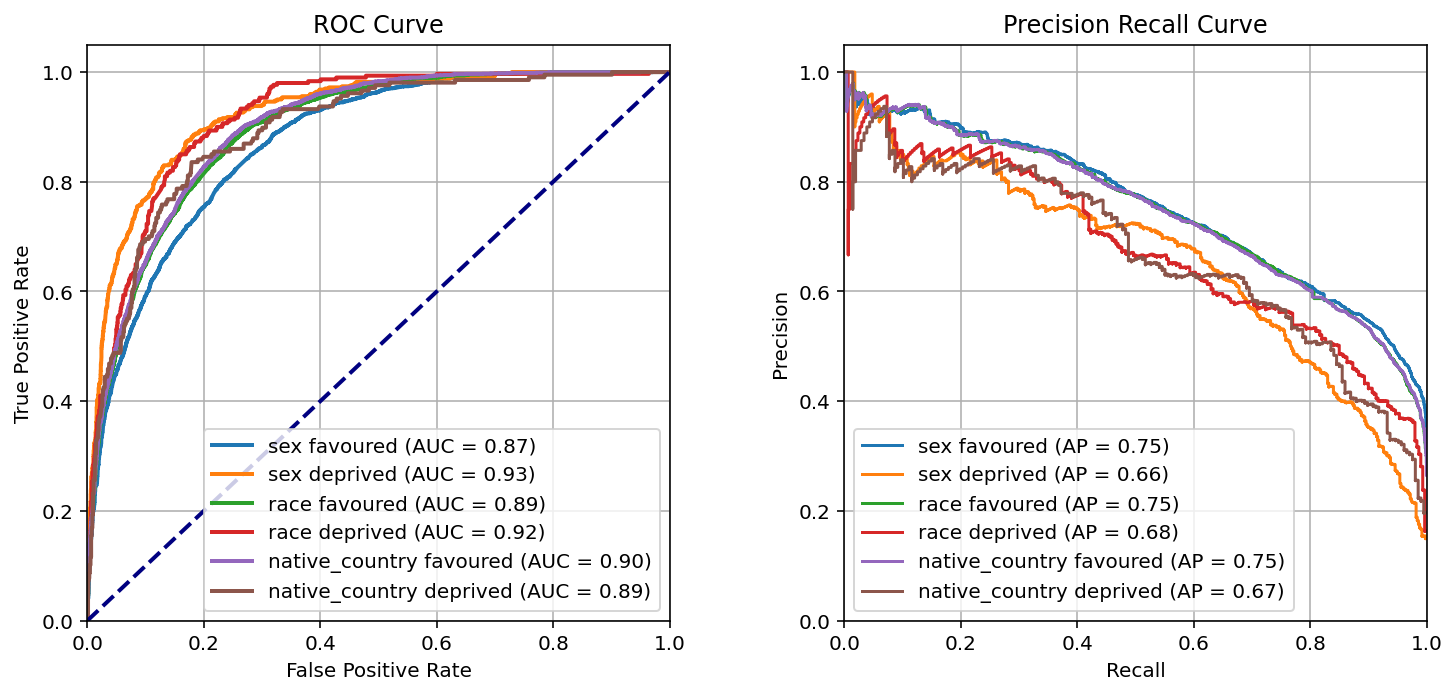

In [20]:
clf_unbiased = train(X_train, y_train, X_test, y_test)
check_bias(clf_unbiased, X_test, y_test, ["sex", "race", "native_country"])

> `clf_unbiased` will serve as the first trained baseline model

# Task 3.4 Fair machine learning implementation

## Implementing Preferential Sampling

In [21]:
from sklearn.naive_bayes import GaussianNB

def disp_impact(df):
    DP = df.query('group == "DP"')
    FP = df.query('group == "FP"')
    DN = df.query('group == "DN"')
    FN = df.query('group == "FN"')
    return (DP.shape[0]/(DP.shape[0] + DN.shape[0]))/(FP.shape[0]/(FP.shape[0] + FN.shape[0]))


def preferential_sample(df, feature, target, balance_value=0.8):
    X, y = encode_and_scale(df.drop([target], axis=1)), df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    R = GaussianNB()
    R.fit(X_train, y_train)
    print("Accuracy of ranker R:", R.score(X_test, y_test))
    df['prob'] = R.predict_proba(X)[:, 1]
    df['group'] = df[feature].map(lambda x: 'D' if x == 0 else 'F') +\
                  df[target].map(lambda x: 'N' if x == 0 else 'P')
    
    DP = df.query('group == "DP"').sort_values(by='prob')
    FP = df.query('group == "FP"').sort_values(by='prob')
    DN = df.query('group == "DN"').sort_values(by='prob', ascending=False)
    FN = df.query('group == "FN"').sort_values(by='prob', ascending=False)
    
    df_, i = df.copy(), 1
    while disp_impact(df_) < balance_value:
        df_ = pd.concat([FP[i:], DN[i:],
                         pd.concat([DP, DP[:i]]), pd.concat([FN, FN[:i]])])
        i += 3
    
    del df['prob']
    del df['group']
    
    return df_.drop(['prob', 'group'], axis=1)

## Evaluating

10 fold corss validation accuracy: 83.86%

                         sex            race           
                         value  biased  value  biased
Statistical Parity Diff -0.164    True -0.074   False
Equal Opportunity Diff  -0.126    True -0.062   False
Average Odds Diff       -0.095   False -0.040   False
Disparate Impact         0.283    True  0.603    True


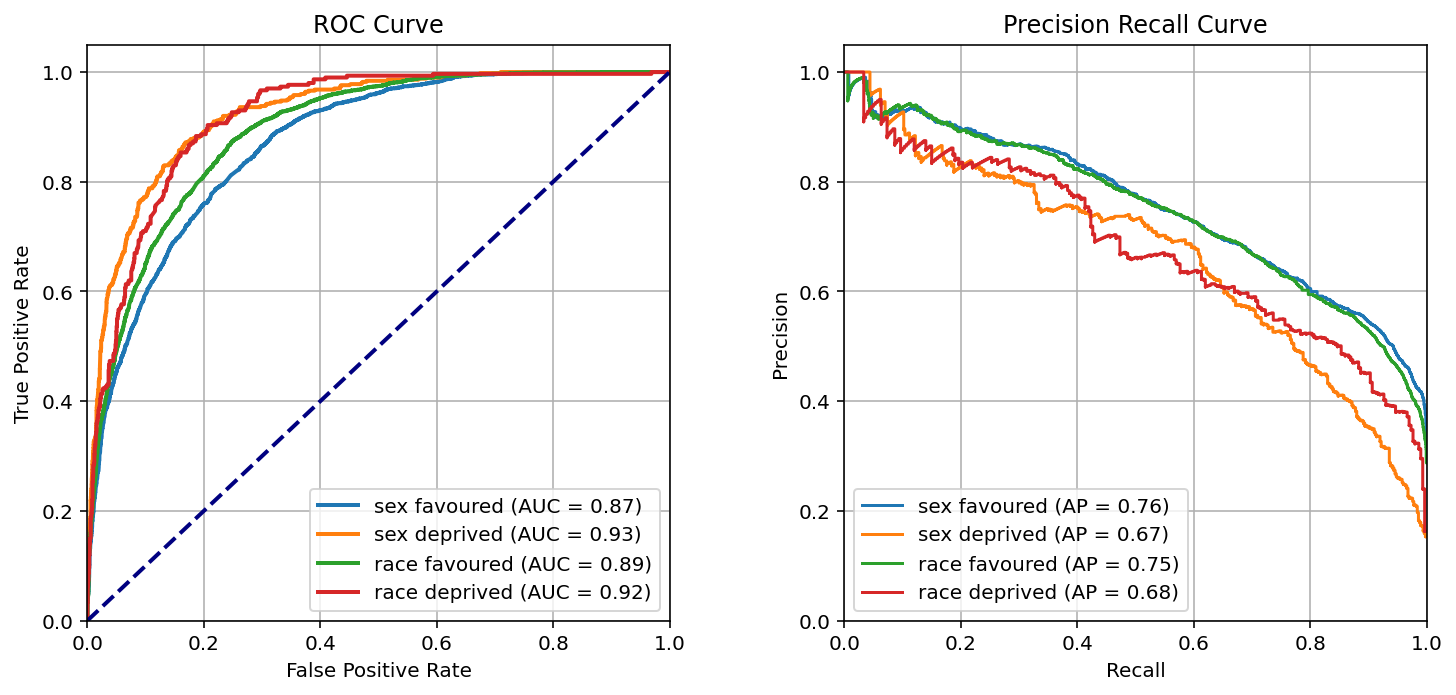

In [22]:
# baseline 2 - train without sex attribute
clf_noSA = train(X_train.drop(['sex'], axis=1), y_train, X_test.drop(['sex'], axis=1), y_test)
check_bias(clf_noSA, X_test, y_test, ['sex', 'race'], exclude_cols=['sex'])

10 fold corss validation accuracy: 83.93%

                         sex            race           
                         value  biased  value  biased
Statistical Parity Diff -0.168    True -0.074   False
Equal Opportunity Diff  -0.138    True -0.061   False
Average Odds Diff       -0.102    True -0.039   False
Disparate Impact         0.280    True  0.607    True


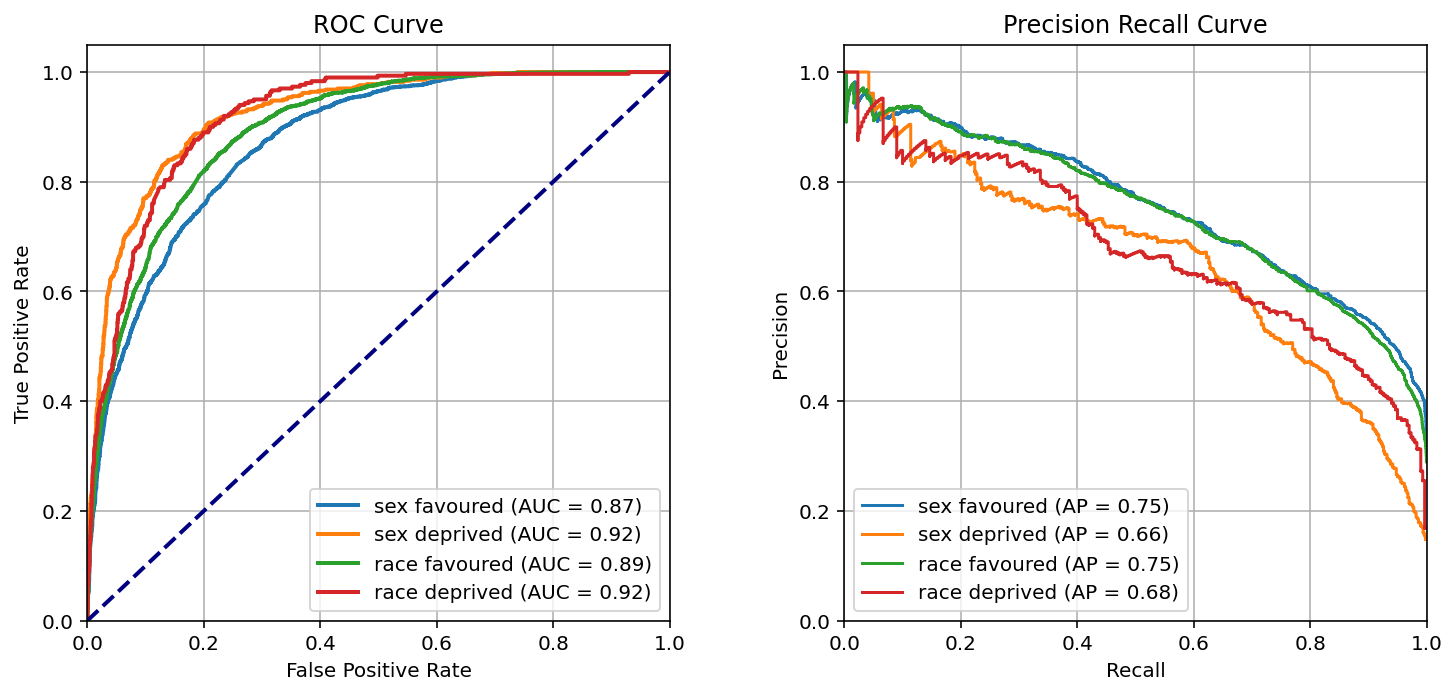

In [23]:
# baseline 3 - train without race attribute
clf_noRA = train(X_train.drop(['race'], axis=1), y_train, X_test.drop(['race'], axis=1), y_test)
check_bias(clf_noRA, X_test, y_test, ['sex', 'race'], exclude_cols=['race'])

Accuracy of ranker R: 0.7968334388853705
Accuracy of ranker R: 0.7970867637745408
10 fold corss validation accuracy: 83.97%

                         sex            race           
                         value  biased  value  biased
Statistical Parity Diff -0.033   False -0.033   False
Equal Opportunity Diff   0.237    True  0.065   False
Average Odds Diff        0.131    True  0.033   False
Disparate Impact         0.832   False  0.823   False


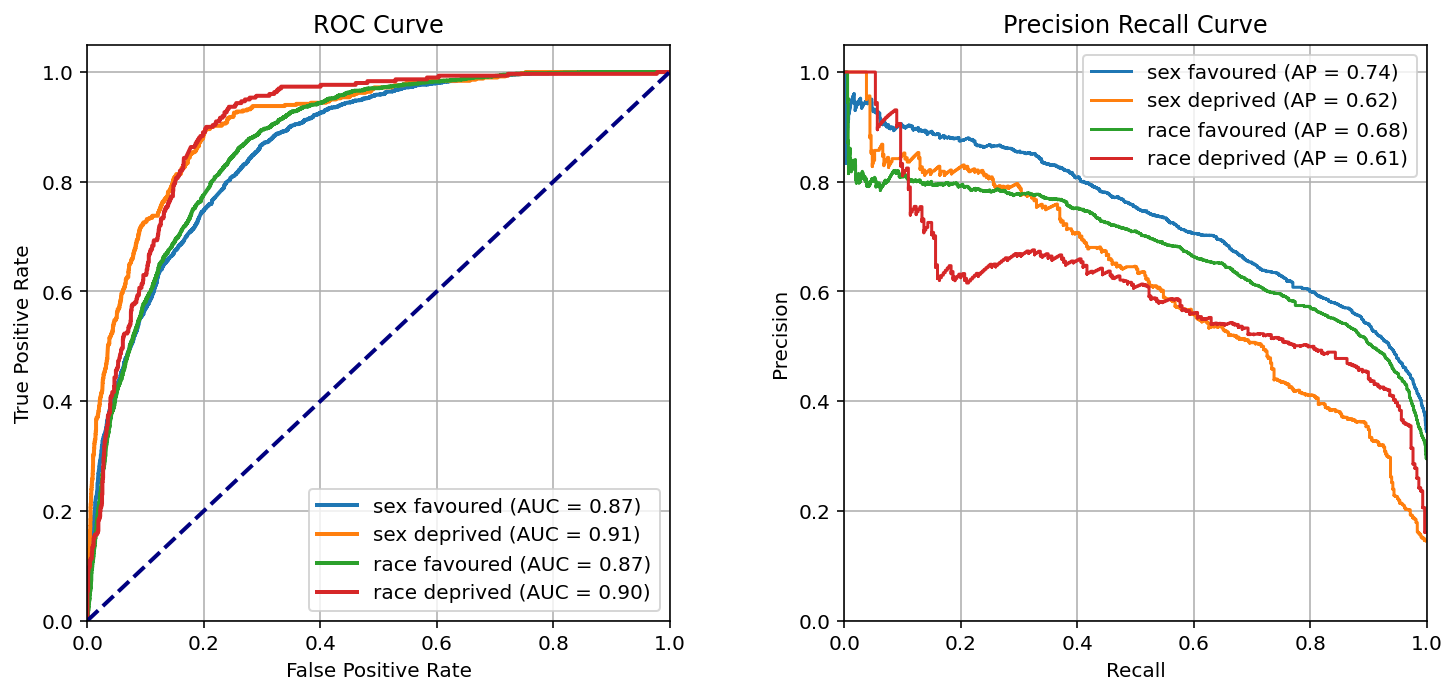

In [24]:
# Preferentially resample test data
train_data = pd.concat([X_train, y_train], axis=1)
disp_free = preferential_sample(train_data, 'sex', 'salary', 0.75)
disp_free = preferential_sample(disp_free, 'race', 'salary', 0.80)
train_data = disp_free.sample(frac=1, random_state=42)

# Model trained on dataset with resampeled test data
X_train_ps, y_train_ps = encode_and_scale(train_data.drop(['salary'], axis=1)), train_data['salary']
clf_PS = train(X_train_ps, y_train_ps, X_test, y_test)
check_bias(clf_PS, X_test, y_test, ['sex', 'race'])